In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
# Configuration
DATA_DIR = "./data"
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCHS = 15
SEED = 42
MODEL_PATH = "solar_panel_classifier.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [18]:
# Load dataset
full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
torch.manual_seed(SEED)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

In [19]:
# WeightedRandomSampler for balanced classes
targets = [train_dataset[i][1] for i in range(len(train_dataset))]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [20]:
# Model - ResNet18
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True  # fine-tune entire model
model.fc = nn.Linear(model.fc.in_features, 6)
model = model.to(device)

c:\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [21]:
# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_preds / len(train_loader.dataset)
        val_acc = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f}, Val Acc={val_acc:.4f}")

# Evaluation

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Get predictions
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds)

In [24]:
# Train
train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

# Evaluate
true_labels, pred_labels = get_predictions(model, val_loader)
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))


Epoch 1/15: 100%|██████████| 23/23 [03:00<00:00,  7.85s/it]


Epoch 1: Loss=0.8710, Train Acc=0.7034, Val Acc=0.7684


Epoch 2/15: 100%|██████████| 23/23 [03:15<00:00,  8.52s/it]


Epoch 2: Loss=0.2828, Train Acc=0.9096, Val Acc=0.8249


Epoch 3/15: 100%|██████████| 23/23 [03:29<00:00,  9.10s/it]


Epoch 3: Loss=0.1824, Train Acc=0.9605, Val Acc=0.8475


Epoch 4/15: 100%|██████████| 23/23 [03:14<00:00,  8.47s/it]


Epoch 4: Loss=0.0932, Train Acc=0.9887, Val Acc=0.8531


Epoch 5/15: 100%|██████████| 23/23 [02:51<00:00,  7.47s/it]


Epoch 5: Loss=0.0624, Train Acc=0.9873, Val Acc=0.8418


Epoch 6/15: 100%|██████████| 23/23 [02:44<00:00,  7.16s/it]


Epoch 6: Loss=0.0590, Train Acc=0.9901, Val Acc=0.8305


Epoch 7/15: 100%|██████████| 23/23 [02:39<00:00,  6.93s/it]


Epoch 7: Loss=0.0390, Train Acc=0.9944, Val Acc=0.8418


Epoch 8/15: 100%|██████████| 23/23 [02:38<00:00,  6.88s/it]


Epoch 8: Loss=0.0530, Train Acc=0.9929, Val Acc=0.8531


Epoch 9/15: 100%|██████████| 23/23 [02:36<00:00,  6.81s/it]


Epoch 9: Loss=0.0532, Train Acc=0.9887, Val Acc=0.8362


Epoch 10/15: 100%|██████████| 23/23 [02:40<00:00,  6.99s/it]


Epoch 10: Loss=0.0368, Train Acc=0.9958, Val Acc=0.8588


Epoch 11/15: 100%|██████████| 23/23 [02:48<00:00,  7.32s/it]


Epoch 11: Loss=0.0413, Train Acc=0.9901, Val Acc=0.8814


Epoch 12/15: 100%|██████████| 23/23 [02:35<00:00,  6.75s/it]


Epoch 12: Loss=0.0714, Train Acc=0.9887, Val Acc=0.8644


Epoch 13/15: 100%|██████████| 23/23 [02:49<00:00,  7.36s/it]


Epoch 13: Loss=0.0364, Train Acc=0.9944, Val Acc=0.8644


Epoch 14/15: 100%|██████████| 23/23 [02:42<00:00,  7.05s/it]


Epoch 14: Loss=0.0499, Train Acc=0.9944, Val Acc=0.8870


Epoch 15/15: 100%|██████████| 23/23 [02:41<00:00,  7.03s/it]


Epoch 15: Loss=0.0425, Train Acc=0.9915, Val Acc=0.8192

Classification Report:

                   precision    recall  f1-score   support

        Bird-drop       0.78      0.81      0.80        43
            Clean       0.81      0.93      0.87        45
            Dusty       0.79      0.70      0.74        33
Electrical-damage       0.90      0.95      0.92        19
  Physical-Damage       0.70      0.54      0.61        13
     Snow-Covered       0.95      0.83      0.89        24

         accuracy                           0.82       177
        macro avg       0.82      0.79      0.80       177
     weighted avg       0.82      0.82      0.82       177



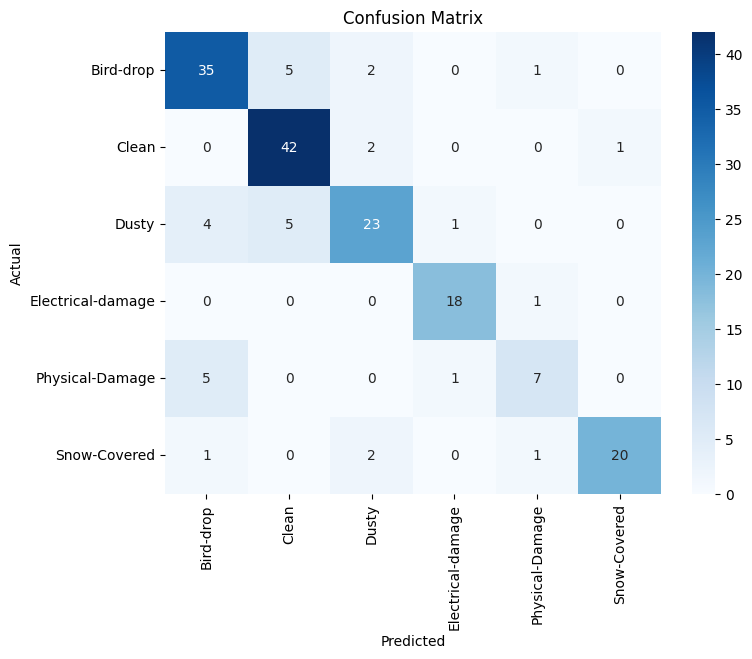

In [25]:
# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save model
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to solar_panel_classifier.pth
